# Imports

In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Point, mapping
from rasterio.crs import CRS
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
import rasterio
from scipy.stats import iqr

# Directory Setup

In [3]:
input_folder = "S1_peakdate_GEE0722/"
output_folder = "outputs"
flood_shp = "shp/filtered_flooding_points_over_one_day.shp"

# Visualize few Imageries

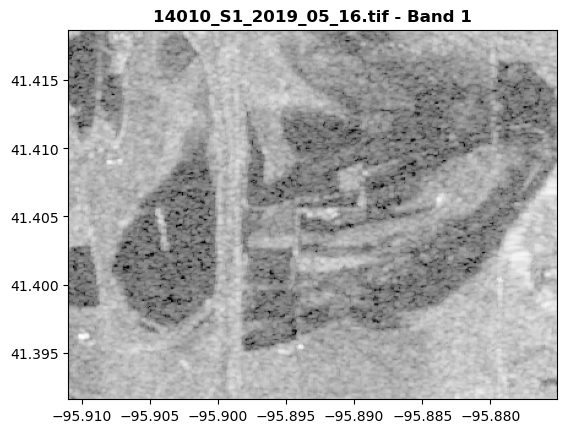

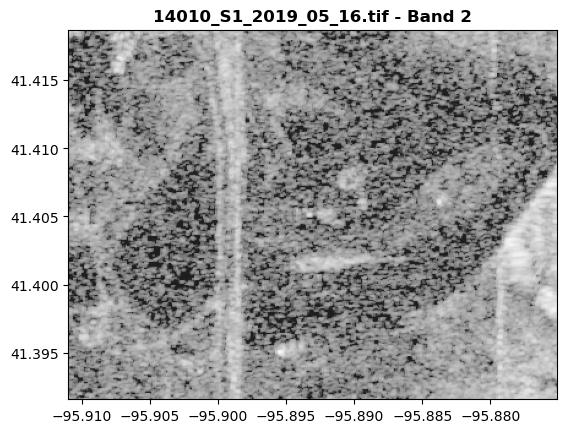

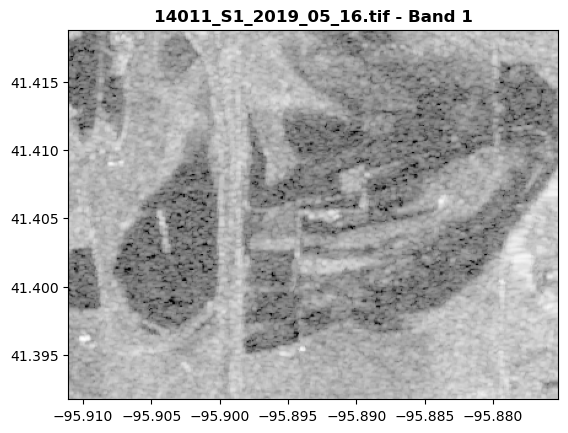

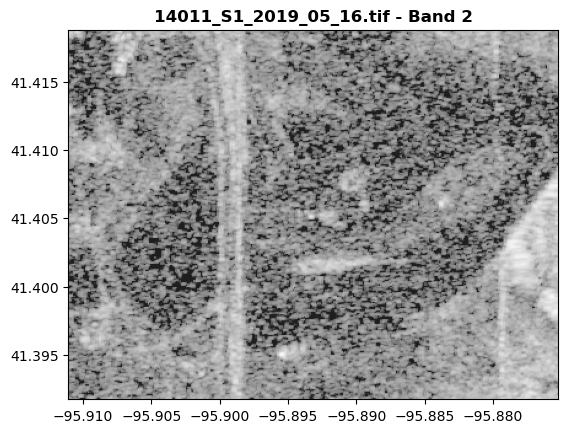

In [4]:
image_paths = sorted(glob.glob(os.path.join(input_folder, "*.tif")))[:2]
for img_path in image_paths:
    with rasterio.open(img_path) as src:
        for i in range(1, src.count + 1):
            show(src.read(i), transform=src.transform, cmap='gray',
                 title=f"{os.path.basename(img_path)} - Band {i}")

# Creating 1.5km Square buffer around the Flood points

In [5]:
# Load & reproject your points into a projected coordinate system
flood_points = gpd.read_file(flood_shp)
flood_proj = flood_points.to_crs('EPSG:3857')

# Create square buffers (1.5 km = 1500 meters)
buffer_distance = 1500 # meters
def create_square_buffer(point, distance):
    x, y = point.x, point.y
    return box(x - distance, y - distance, x + distance, y + distance)

flood_proj['square_buffer'] = flood_proj.geometry.apply(
    lambda pt: create_square_buffer(pt, buffer_distance)
)
flood_buffer = flood_proj.copy()
flood_buffer.geometry = flood_buffer['square_buffer']

flood_buffer = flood_buffer[['ID', 'peak_date', 'square_buffer']]
flood_buffer
flood_buffer["buffer_area_m2"] = flood_buffer.geometry.area
flood_buffer = flood_buffer.to_crs(flood_points.crs)# Reprojected back to the original CRS if needed
print(f"Created {len(flood_buffer)} square buffers")
flood_buffer_path = os.path.join(output_folder, "flood_buffer_squares.shp")
flood_buffer.to_file(flood_buffer_path)
print(f"flood_buffers exported to '{flood_buffer_path}' ")

C:\Users\AKINBOYEWA TEMITOPE\.conda\envs\Autonomous_Geographic_Modeling\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


Created 1219 square buffers
flood_buffers exported to 'outputs\flood_buffer_squares.shp' 


C:\Users\AKINBOYEWA TEMITOPE\AppData\Local\Temp\ipykernel_3540\2968599911.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flood_buffer.to_file(flood_buffer_path)
C:\Users\AKINBOYEWA TEMITOPE\.conda\envs\Autonomous_Geographic_Modeling\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'buffer_area_m2' to 'buffer_are'
  ogr_write(


# Clipping Raster to the Buffer

In [6]:
# === Loop through all IDs ===
for idx, row in flood_buffer.iterrows():
    id_val = str(row["ID"])  # ID should match the file naming convention
    geom = [mapping(row["square_buffer"])]
    # === Find matching raster with glob
    pattern = os.path.join(input_folder, f"{id_val}_S1_*.tif")
    matched_files = glob.glob(pattern)

    if not matched_files:
        print(f"No raster found for ID {id_val}")
        continue

    raster_path = matched_files[0]  # Use first match (or loop if multiple)
    # print(f"\nProcessing ID {id_val} → {os.path.basename(raster_path)}")


    # === Clip raster ===
    with rasterio.open(raster_path) as src:
        if src.count < 2:
            print(f"Raster for ID {id_val} does not have 2 bands. Skipping.")
            continue

        # Clip the full raster

        out_image, out_transform = mask(src, geom, crop=True)
        out_meta = src.meta.copy()

    # === Update metadata for output ===
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })




        # === Save clipped image ===
    # output_path = os.path.join(output_folder,"clipped_2bands" f"clipped_{id_val}.tif")
    # with rasterio.open(output_path, "w", **out_meta) as dest:
    #     dest.write(out_image)
    #
    # print(f"Saved: {output_path}")

    # === Save VV (band 1)
    single_band_folder = os.path.join(output_folder, "clipped_single_band")
    os.makedirs(single_band_folder, exist_ok=True)
    vv_path = os.path.join(single_band_folder, f"clipped_VV_{id_val}.tif")
    with rasterio.open(vv_path, "w", **out_meta) as dest:
        dest.write(out_image[0],1)  # Write only band 1 (VV)
    #
    # === Save VH (band 2)
    vh_path = os.path.join(single_band_folder, f"clipped_VH_{id_val}.tif")
    with rasterio.open(vh_path, "w", **out_meta) as dst:
        dst.write(out_image[1],1)  # Write only band 2 (VH)
    #
    # print(f"  Saved VV: {vv_path}")
    # print(f"  Saved VH: {vh_path}")
print("Saved VV and VH clipped rasters")

Saved VV and VH clipped rasters


# Extracting Features from clipped imageries

In [7]:
# === Function to extract stats from a single-band raster ===
def compute_stats(tif_path):
    with rasterio.open(tif_path) as src:
        band = src.read(1).astype(np.float32)
        if src.nodata is not None:
            band = np.ma.masked_equal(band, src.nodata)
        band_flat = band.compressed() if np.ma.isMaskedArray(band) else band.flatten()

    return {
        "Min": np.min(band_flat),
        "Max": np.max(band_flat),
        "Mean": np.mean(band_flat),
        "IQR": iqr(band_flat),
        "SD": np.std(band_flat)
    }

In [8]:
# === Load peak dates from flood
flood_points = gpd.read_file(flood_shp)

flood_points["ID"] = flood_points["ID"].astype(str)

id_to_peak_date = flood_points.set_index("ID")["peak_date"].to_dict()


# === Setup ===
input_folder = "outputs/clipped_single_band"
output_csv = "outputs/sentinel1_combined_features.csv"

# === Adjusted file pattern for your naming convention
vv_files = sorted(glob.glob(os.path.join(input_folder, "clipped_VV_*.tif")))
vh_files = sorted(glob.glob(os.path.join(input_folder, "clipped_VH_*.tif")))

# Extract IDs from filenames like: clipped_VV_14061.tif
vv_dict = {os.path.basename(f).replace("clipped_VV_", "").replace(".tif", ""): f for f in vv_files}
vh_dict = {os.path.basename(f).replace("clipped_VH_", "").replace(".tif", ""): f for f in vh_files}

# Match only IDs that exist in both VV and VH
common_ids = sorted(set(vv_dict.keys()) & set(vh_dict.keys()))

results = []

for id_val in common_ids:
    vv_stats = compute_stats(vv_dict[id_val])
    vh_stats = compute_stats(vh_dict[id_val])

    # Compute VH/VV ratio using mean values
    vv_mean = vv_stats["Mean"]
    vh_mean = vh_stats["Mean"]
    vh_vv_ratio = vh_mean / vv_mean if vv_mean != 0 else np.nan
    peak_date = id_to_peak_date.get(id_val, "NA")

    results.append({
        "ID": id_val,
        "peak_date": peak_date,
        "VV_Min": vv_stats["Min"],
        "VV_Max": vv_stats["Max"],
        "VV_Mean": vv_mean,
        "VV_IQR": vv_stats["IQR"],
        "VV_SD": vv_stats["SD"],
        "VH_Min": vh_stats["Min"],
        "VH_Max": vh_stats["Max"],
        "VH_Mean": vh_mean,
        "VH_IQR": vh_stats["IQR"],
        "VH_SD": vh_stats["SD"],
        "VH_VV_Ratio": vh_vv_ratio
    })

# === Save to CSV
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"\n✔ Features extracted and saved to: {output_csv}")


✔ Features extracted and saved to: outputs/sentinel1_combined_features.csv
